The data is loaded from an Excel file including various economic indicators and stock price changes over time.

In [5]:
import pandas as pd



# Read the Excel file into a Pandas DataFrame
df = pd.read_excel('data.xlsx')

# Display the first few rows of the DataFrame
df.head()


,Unnamed: 0,scpi,oil,ip,inflation,ner,policy,stock
0,2003m1,-0.56,43.041389,2.786890,2.376910,-2.158789,1.25,-19.701227
1,2003m2,-0.47,46.361003,2.789881,2.597403,-4.601272,1.25,-23.922969
2,2003m3,-0.34,22.869140,2.136833,2.980877,-5.218402,1.25,-29.725152
3,2003m4,-0.23,-3.572159,1.178375,3.020134,-5.043928,1.25,-22.228481
4,2003m5,-0.50,0.643650,0.747467,2.224694,-5.423623,1.25,-14.310084


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  249 non-null    object 
 1   scpi        249 non-null    float64
 2   oil         249 non-null    float64
 3   ip          249 non-null    float64
 4   inflation   249 non-null    float64
 5   ner         249 non-null    float64
 6   policy      249 non-null    float64
 7   stock       249 non-null    float64
dtypes: float64(7), object(1)
memory usage: 15.7+ KB


In [7]:
df.describe()

,scpi,oil,ip,inflation,ner,policy,stock
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,0.143092,5.821057,0.293063,2.545302,0.166412,1.431225,4.924073
std,1.056727,36.384931,5.299659,1.908587,5.854700,1.683231,16.828713
min,-1.580000,-97.914542,-21.709515,-2.097161,-11.018247,0.125000,-61.591583
25%,-0.510000,-13.176610,-0.805644,1.512203,-4.257717,0.125000,-3.013411
50%,-0.130000,7.501176,1.291623,2.158273,0.089132,0.625000,8.825069
75%,0.410000,35.408835,2.822572,3.266195,3.863958,2.125000,14.725146
max,4.320000,89.232077,18.837522,9.059758,15.663796,5.375000,43.796428


The data is visualized to understand the trends and patterns in stock price changes over time. The stationarity of the data is checked using the Augmented Dickey-Fuller (ADF) test.

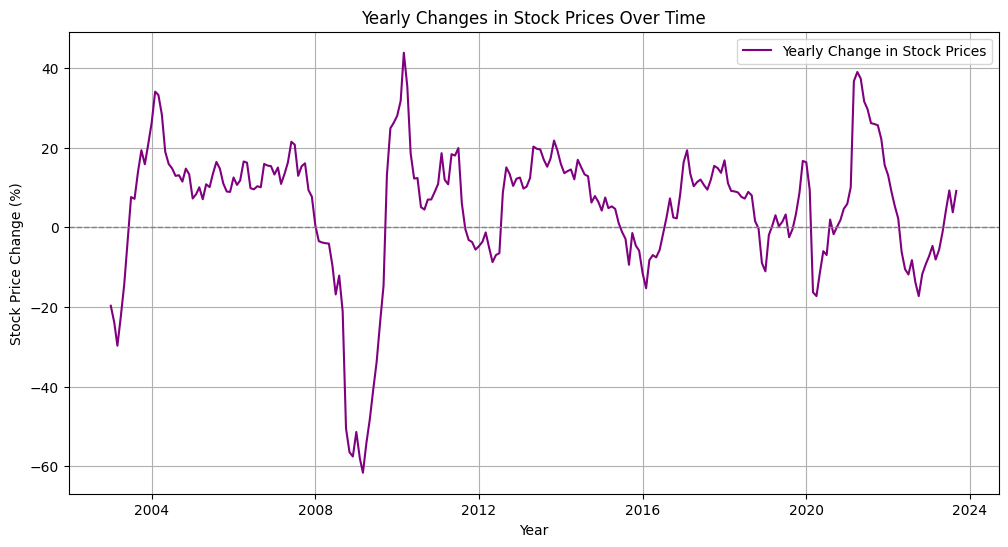

In [14]:
import matplotlib.pyplot as plt

# Convert 'Unnamed: 0' to datetime format (assuming "YYYYmM" structure)
df['date'] = pd.to_datetime(df['Unnamed: 0'].str.replace('m', '-'), format='%Y-%m')

# Set the new date column as the index
df.set_index('date', inplace=True)

# Plot stock price changes over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['stock'], label="Yearly Change in Stock Prices", color='purple', linewidth=1.5)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # Reference line at 0
plt.title("Yearly Changes in Stock Prices Over Time")
plt.xlabel("Year")
plt.ylabel("Stock Price Change (%)")
plt.legend()
plt.grid(True)
plt.show()


The stationarity of the data is checked using the Augmented Dickey-Fuller (ADF) test.

In [15]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series.dropna())  # Drop NaN values for the test
    return {"Test Statistic": result[0], "p-value": result[1]}

# Apply ADF test to all numerical columns
stationarity_results = {col: adf_test(df[col]) for col in df.columns if col != "Unnamed: 0"}

# Convert results to DataFrame for better readability
stationarity_df = pd.DataFrame.from_dict(stationarity_results, orient="index")

# Display stationarity results
print(stationarity_df)


           Test Statistic   p-value
scpi            -3.229062  0.018363
oil             -3.426560  0.010086
ip              -3.344942  0.012985
inflation       -2.459798  0.125565
ner             -2.888590  0.046691
policy          -2.783278  0.060702
stock           -4.228510  0.000589


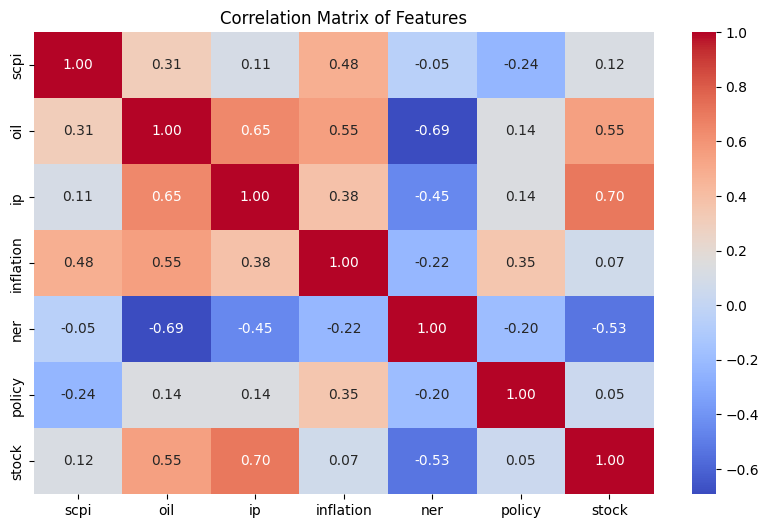

ip           0.703998
oil          0.547375
ner          0.529507
scpi         0.122984
inflation    0.071865
policy       0.046486
Name: stock, dtype: float64


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the dataframe only contains numeric columns
df_numeric = df.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

# Sort features by correlation with 'stock'
if 'stock' in correlation_matrix.columns:
    correlation_with_stock = correlation_matrix["stock"].drop("stock").abs().sort_values(ascending=False)
    print(correlation_with_stock)


The top three features most correlated with stock price changes are:

1- Industrial Production (ip) (0.70 correlation)
2- Oil Prices (oil) (0.55 correlation)
3- Nominal Exchange Rate (ner) (0.53 correlation)

In [22]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

# Check stationarity of 'stock' (since LSTMs work better with stationary data)
adf_result = adfuller(df["stock"].dropna())
stock_stationary = adf_result[1] < 0.05  # p-value < 0.05 means stationary

# Prepare data for VAR model (which helps determine optimal lag length)
selected_features = ["stock", "ip", "oil", "ner"]
df_selected = df[selected_features].dropna()

# Fit a VAR model and select the optimal number of lags
var_model = VAR(df_selected)
lag_selection = var_model.select_order(maxlags=12)  # Test up to 12 lags
optimal_lag = lag_selection.aic

optimal_lag


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


4

The LSTM model is set up using the optimal lag length determined by the VAR model. The optimal number of lags are 4.

The data is split into training and testing sets, and sequences are created for the LSTM model.

Training and testing sets

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data (assuming df is already loaded)
features = ["ip", "oil", "ner"]
target = "stock"
data = df[features + [target]].dropna()

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, lags):
    X, y = [], []
    for i in range(lags, len(data)):
        X.append(data[i-lags:i, :-1])  # Use past 'lags' timesteps for features
        y.append(data[i, -1])          # Target is the current stock price
    return np.array(X), np.array(y)

lags = 4  # Optimal lag length
X, y = create_sequences(scaled_data, lags)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense output layer
model.add(Dense(units=1))  # Single output for stock price prediction

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 4, 50)               │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.4483 - val_loss: 0.2692
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2376 - val_loss: 0.0950
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0785 - val_loss: 0.0435
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0440 - val_loss: 0.0547
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0262 - val_loss: 0.0310
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0273 - val_loss: 0.0312
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0254 - val_loss: 0.0303
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0251 - val_loss: 0.0322
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0228 - val_loss: 0.0309
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0266 - val_loss: 0.0295
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0263 - val_loss: 0.0293
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0224 - val_loss: 0.0300


Evaluate the Model

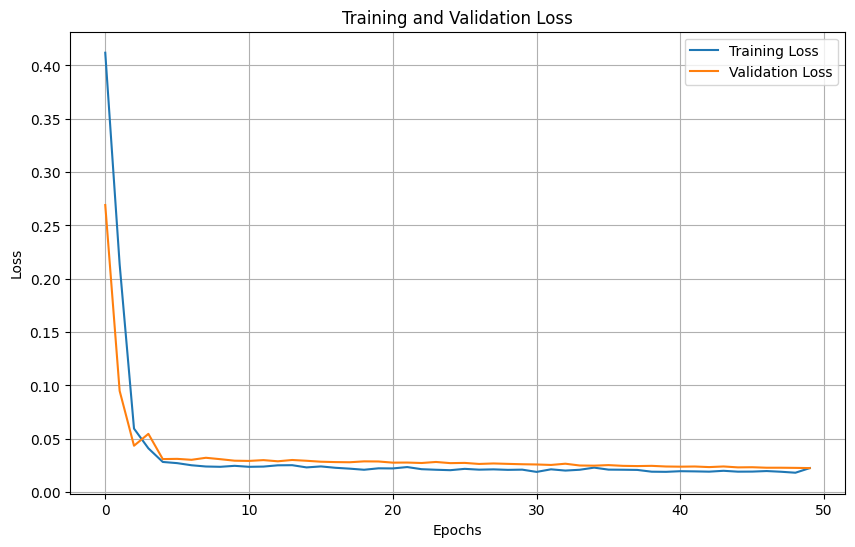

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


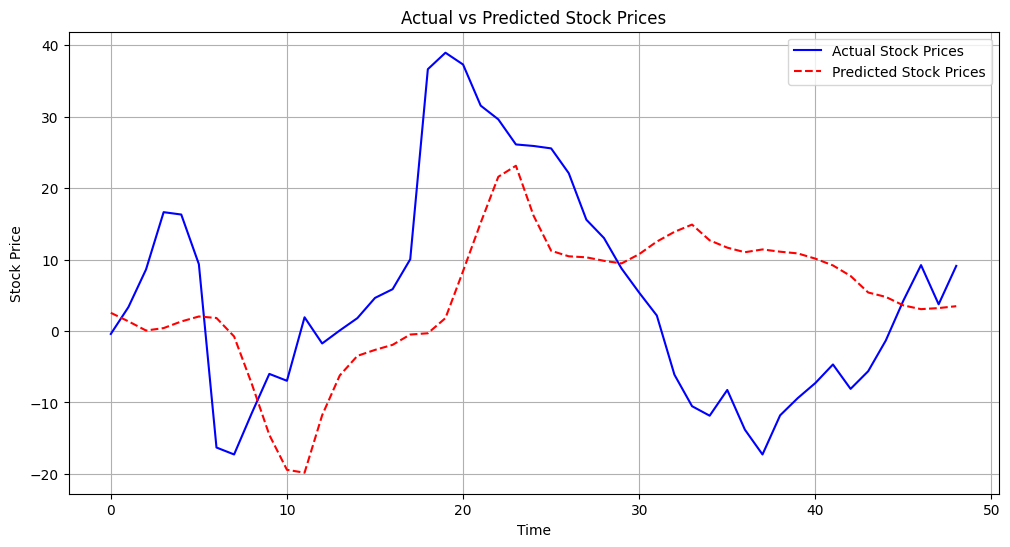

In [31]:

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred.reshape(-1, 1)), axis=1))[:, -1]
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

# Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Stock Prices", color="blue")
plt.plot(y_pred_actual, label="Predicted Stock Prices", color="red", linestyle="--")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

The model's performance is evaluated using metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 12.974435180706648
Root Mean Squared Error (RMSE): 15.826293823461329
